# **KNN**

In [1]:
import pandas as pd

### **Data Preprocessing**

import training and test dataset

In [2]:
train_data = pd.read_csv('../dataset/train_data.csv')
train_labels = pd.read_csv('../dataset/train_labels.csv')
test_data = pd.read_csv('../dataset/test_data.csv')
test_labels = pd.read_csv('../dataset/test_labels.csv')

In [3]:
print(f"Number of data points in the training set: {train_data.shape[0]}")
print(f"Number of data points in the test set: {test_data.shape[0]}")

Number of data points in the training set: 373598
Number of data points in the test set: 35406


Define the categorical and numeric features. K-NN requires only numeric features. Standardize the numeric features to ensure all variables have the same importance in distance calculations, as K-NN is sensitive to differences in scale.

In [4]:
columns_to_drop = ['_url', 'name',  'profile', 'length',
                            'startlist_quality', 'position', 'cyclist', 'cyclist_team', 
                            'duration', 'cyclist_experience_profile',
                            'cyclist_experience_length', 'cyclist_experience_climb', 
                            'avg_rel_position_length', 'avg_rel_position_climb', 
                            'relative_position_sum', 'relative_position',
                            "climb_cat", "length_cat", "cyclist_number", 
                            "avg_rel_position_profile", "points", 'is_tarmac', 
                            'avg_cyclist_level']

train_data.drop(columns=columns_to_drop, inplace=True)
test_data.drop(columns=columns_to_drop, inplace=True)

## Preprocessing Pipeline

In [5]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from imblearn.pipeline import Pipeline 


In [6]:
numeric_features = train_data.columns

numeric_transformer = StandardScaler()

# Create the preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
    ])

## **K-NN**

In [7]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, confusion_matrix, get_scorer, make_scorer
from imblearn.combine import SMOTETomek
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler, NearMiss

import matplotlib.pyplot as plt
import sys
sys.path.append('..')
from utils import sensitivity_score, specificity_score, precision_with_zero_division, recall_with_zero_division

**NOTES during training:**  
- Without oversampling, the model tends to overfit, selecting the smallest \( k \) value (3) as optimal and producing highly unbalanced results in favor of class 0.  
- With oversampling, the model prefers configurations with larger \( k \) values and achieves more balanced performance. The selection of a higher \( k \) suggests that the input data is not very representative of the class distribution, making it harder for the model to make accurate predictions.  
- With undersampling, the model achieves balanced results but does not show the best performance. It consistently selects the highest \( k \) value.  
- Using SMOTETomek, the model selects a relatively high \( k \) value (11, though not the highest possible). The results are balanced, but the overall performance is not optimal.  
- With SMOTE oversampling, the results are balanced but similar to those with SMOTETomek, with the same choice of the best \( k \).  
- NEARMISS produces the worst-performing model, suffering from significant underfitting.

In [8]:
# Model k-NN
clf = KNeighborsClassifier()

# Define the model Pipeline
model = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("resempling", RandomOverSampler(sampling_strategy=0.35, random_state=42)),
        ("clf", clf)
    ]
)

# Define the parameters to search
parameters = {
    'clf__n_neighbors': [5, 7, 9, 11, 13, 15], 
    'clf__leaf_size': [5, 10, 20, 30, 40, 50],
    'clf__weights': ['uniform', 'distance'],      
    'clf__algorithm': ['auto'], 
    'clf__metric': ['euclidean', 'manhattan'],     
    'clf__p': [1, 2, 3]     
}

# Define the scoring functions
scoring = {
    'sensitivity': make_scorer(sensitivity_score),
    'specificity': make_scorer(specificity_score),
    'accuracy': get_scorer("accuracy"),
    'precision': make_scorer(precision_with_zero_division),
    'recall': make_scorer(recall_with_zero_division),
    'roc_auc': get_scorer("roc_auc"),
    'f1': get_scorer("f1")
}

# Define the RandomizedSearchCV
rscv = RandomizedSearchCV(
    model,
    param_distributions=parameters,
    scoring=scoring,
    n_iter=50,  
    cv=5, 
    verbose=1,
    n_jobs=-1,
    random_state=42,
    refit="f1",  
)


# Addestramento
rscv.fit(train_data, train_labels.values.ravel())


Fitting 5 folds for each of 50 candidates, totalling 250 fits


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               StandardScaler(),
                                                                               Index(['climb_total', 'cyclist_age', 'cyclist_level', 'cyclist_experience',
       'avg_relative_position', 'position_entropy', 'top_20_entropy'],
      dtype='object'))])),
                                             ('resempling',
                                              RandomOverSampler(random_state=42,
                                                                sampling_strategy=0.35)),
                                             ('...
                            'precision': make_scorer(precision_with_zero_division, response_method='predict'),
                            'recall': make_scorer(recall_with_zero_division, response_method='predict'),
                            'roc_auc': make_scorer(roc_auc_score, response_method=('decision_function', 'predict_proba')),
                            'sensitivity': make_scorer(sensitivity_score, response_method='predict'),
                            'specificity': make_scorer(specificity_score, response_method='predict')},
                   verbose=1)

## Model Assessment

### Validation scores:

In [9]:
# extract the results of the randomized search and best model idx
cv_results = rscv.cv_results_
best_model = rscv.best_estimator_
best_index = rscv.best_index_

#extract and print matrics
mean_test_scores = {metric: cv_results[f'mean_test_{metric}'][best_index] for metric in scoring.keys()}
std_test_scores = {metric: cv_results[f'std_test_{metric}'][best_index] for metric in scoring.keys()}

print("Validation results of the best model:")
for metric in scoring.keys():
    print(f"{metric.capitalize()} - Mean: {mean_test_scores[metric]:.4f}, Std: {std_test_scores[metric]:.4f}")



Validation results of the best model:
Sensitivity - Mean: 0.3970, Std: 0.0049
Specificity - Mean: 0.9005, Std: 0.0019
Accuracy - Mean: 0.8336, Std: 0.0014
Precision - Mean: 0.3793, Std: 0.0039
Recall - Mean: 0.3970, Std: 0.0049
Roc_auc - Mean: 0.7468, Std: 0.0024
F1 - Mean: 0.3879, Std: 0.0033


### Test scores:

Accuracy: 0.793
Recall: 0.389
Precision: 0.326
Sensitivity: 0.389
Specificity: 0.862
F1 Score: 0.355
ROC AUC Score: 0.626


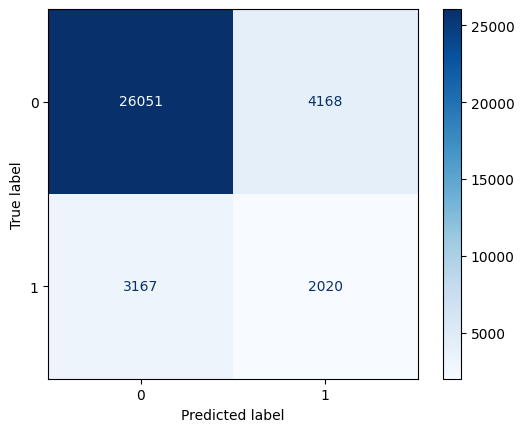

In [10]:
# Predict on the test data
test_predictions = rscv.predict(test_data)

# Calculate and visualize evaluation metrics
accuracy = round(accuracy_score(test_labels, test_predictions), 3)
recall = round(recall_with_zero_division(test_labels, test_predictions), 3)
precision = round(precision_with_zero_division(test_labels, test_predictions), 3)
sensitivity_score = round(sensitivity_score(test_labels, test_predictions), 3)
specificity_score = round(specificity_score(test_labels, test_predictions), 3)
f1 = round(f1_score(test_labels, test_predictions), 3)
roc_auc = round(roc_auc_score(test_labels, test_predictions), 3)
conf_matrix = confusion_matrix(test_labels, test_predictions)

print(f"Accuracy: {accuracy}")
print(f"Recall: {recall}")
print(f"Precision: {precision}")
print(f"Sensitivity: {sensitivity_score}")
print(f"Specificity: {specificity_score}")
print(f"F1 Score: {f1}")
print(f"ROC AUC Score: {roc_auc}")

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot(cmap=plt.cm.Blues)
plt.show()


In [11]:
report = classification_report(test_labels, test_predictions)
print(report)

              precision    recall  f1-score   support

           0       0.89      0.86      0.88     30219
           1       0.33      0.39      0.36      5187

    accuracy                           0.79     35406
   macro avg       0.61      0.63      0.62     35406
weighted avg       0.81      0.79      0.80     35406



In [12]:
import joblib
import os

# Create the directory if it doesn't exist
os.makedirs('best_models', exist_ok=True)
# Save the best model
joblib.dump(best_model, 'best_models/knn.pkl')

['best_models/knn.pkl']

The KNN model shows highly unbalanced performance, favoring class 0 while demonstrating poor capability in identifying class 1. This behavior is expected given the dataset's imbalance. Since KNN relies on the proximity of neighbors for classification, the dominance of class 0 skews predictions. Test samples, especially near decision boundaries, are more likely to have neighbors from the majority class, leading to a bias in favor of class 0. The minority class (class 1) is underrepresented in these local neighborhoods, limiting the model's ability to correctly classify instances belonging to it.